In [5]:
%cd /home/tuyendv/Desktop/mbf_ir/
import json
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
from underthesea import sent_tokenize

/home/tuyendv/Desktop/mbf_ir


In [3]:
def split_sent(sent, max_length=256, max_overlap_length=128):
    words = sent.split(" ")
    sents = []
    
    n = int(len(words)/max_overlap_length) + 1
    for i in range(n):
        sents.append(" ".join(words[i*max_overlap_length: i*max_overlap_length + max_length]))
        
    return sents

In [4]:
def split_doc_in_sent_level(doc, max_length=256, max_overlap_length=128):
    chunks = []
    current_chunk = ""
    current_length = 0
    
    index = 0
    remain_overlap_length = max_overlap_length
    while index < len(doc):
        sent = doc[index]
        if len(sent.split(" ")) > max_length:
            sents = split_sent(sent, max_length=max_length, max_overlap_length=max_overlap_length)
            chunks += sents
        elif current_length + len(sent.split(" ")) > max_length:
            chunks.append(current_chunk)
            while len(doc[index].split(" ")) < remain_overlap_length:
                remain_overlap_length -=len(doc[index].split(" "))
                if index == 0:
                    break
                index -= 1
            index += 1
            if index == len(doc):
                break
            current_chunk = doc[index]
            current_length = len(current_chunk.split(" "))
            remain_overlap_length = max_overlap_length
        else:
            current_chunk = current_chunk + " " + sent
            current_length = len(current_chunk.split(" "))
        
        index += 1
    chunks.append(current_chunk)
    
    return chunks

In [6]:
data_dir = "/home/tuyendv/Desktop/mbf_ir/data/vnexpress/*.json"
docs = []
for _file in glob(data_dir):
    data = json.load(open(_file, "r", encoding="utf-8"))
    content = data["content"]
    
    docs.append(sent_tokenize(content))

In [7]:
chunks = []
for doc in docs:
    chunk = split_doc_in_sent_level(doc)
    chunks += chunk

In [8]:
passages = pd.DataFrame(chunks, columns=["passage_text"])
passages.head()

,passage_text
0,"""Đây là khoảnh khắc đặc biệt"", Haaland nói tạ..."
1,Tôi thực sự thích nó và có rất nhiều cầu thủ g...
2,Chúng tôi tập trung và đạt được điều mong muốn...
3,Tại giải cờ vua Đại kiện tướng quốc tế 2023 ở...
4,"12 GM trước đó lần lượt là Đào Thiên Hải, Từ H..."


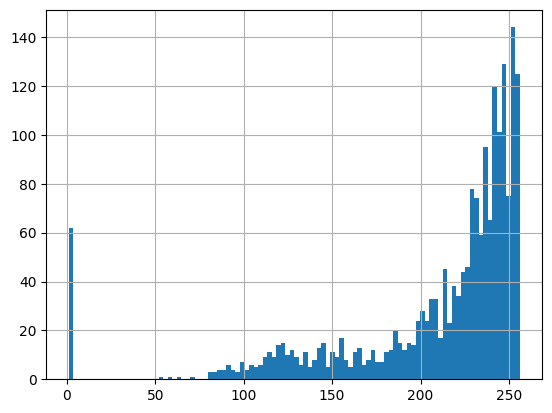

In [12]:
passages["length"] = passages.passage_text.apply(lambda x: len(x.split(" ")))
passages[passages.length!=0]["length"].hist(bins=100)

In [11]:
passages.to_csv("/home/tuyendv/Desktop/mbf_ir/data/vnexpress/passage.txt")

### train bm25

In [13]:
%cd /home/tuyendv/Desktop/mbf_ir/demo
import json
import os
from glob import glob
from tqdm import tqdm
from underthesea import sent_tokenize
from utils import norm_text
import pandas as pd
from bm25 import BM25

/home/tuyendv/Desktop/mbf_ir/demo


In [14]:
path="/home/tuyendv/Desktop/mbf_ir/data/vnexpress/passage.txt"
passages = pd.read_csv(path, index_col=0)
passages.dropna(inplace=True)
passages.head()

,passage_text,length
0,"""Đây là khoảnh khắc đặc biệt"", Haaland nói tạ...",229
1,Tôi thực sự thích nó và có rất nhiều cầu thủ g...,246
2,Chúng tôi tập trung và đạt được điều mong muốn...,149
3,Tại giải cờ vua Đại kiện tướng quốc tế 2023 ở...,256
4,"12 GM trước đó lần lượt là Đào Thiên Hải, Từ H...",136


In [15]:
bm25_model = BM25()
bm25_model.train(passages)

In [16]:
path="/home/tuyendv/Desktop/mbf_ir/demo/checkpoints/bm25"
bm25_model.save(path)

In [21]:
query = """Trước chung kết Champions League mùa 2022-2023, Man City được đánh giá cao hơn hẳn Inter. Thống """
bm25_model.search(query=query, topk=5)

[[27.593296,
  ' "Trên sân, tôi đã nói với đồng đội rằng Inter thiếu nhận thức về việc có thể làm tổn thương Man City", Acerbi nói trong buổi họp báo tại Coverciano, Italy ngày 12/6. "Đã có quá nhiều lời bàn tán về việc Man City mạnh thế nào. Nhưng Man City sợ chúng tôi, họ được đánh giá cao hơn và chúng tôi lẽ ra phải tận dụng tối đa điều đó".Acerbi trong một pha truy cản thành công Haaland ở chung kết Champions League trên sân Ataturk, Istanbul, Thổ Nhĩ Kỳ ngày 10/6. Ảnh: AFPTrước chung kết Champions League mùa 2022-2023, Man City được đánh giá cao hơn hẳn Inter. Thống kê Opta nhận định cơ hội để đại diện Ngoại hạng Anh thắng lên tới 74%, gần gấp ba lần Inter. Danh thủ Xứ Wales Gareth Bale thậm chí dự đoán Man City sẽ thắng 5-0.Nhưng khi vào trận, Inter thi đấu ngang ngửa và thậm chí dứt điểm, tạo cơ hội nhiều hơn Man City. Đại diện Italy cầm bóng 44%, dứt điểm 14 lần với sáu cú trúng đích - so với 7 và 4 của đối thủ, và tạo nhiều cơ hội. Nguy hiểm nhất là tình huống ở phút 71, khi F